In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")
df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# удалим данные для дальнейшей обработки
cols_to_drop= ['CC50, mM', 'IC50, mM', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)

In [37]:
df.head()

,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
3,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,0,4,0
4,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0


Согласно иследованию EDA

Топ-10 наиболее важных дескрипторов для SI:

VSA_EState6            0.436771

VSA_EState2            0.073177

MinPartialCharge       0.046888

BalabanJ               0.039939

qed                    0.036372

MaxAbsPartialCharge    0.035627

VSA_EState8            0.015990

VSA_EState9            0.013150

BCUT2D_MRLOW           0.010328

FpDensityMorgan1       0.009884

### Подготовка данных и обработка выбросов

In [38]:
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

# Рассчитываем медиану и межквартильный размах для фильтрации выбросов
median_cc50 = df['SI'].median()
q1 = df['SI'].quantile(0.25)
q3 = df['SI'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Фильтрация выбросов
df = df[(df['SI'] >= lower_bound) & (df['SI'] <= upper_bound)].copy()
filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")

# Создание целевой переменной на основе медианы
median_value = df['SI'].median()
df['SI_Above_Median'] = (df['SI'] > median_value).astype(int)
target = 'SI_Above_Median'

Исходное количество записей: 1001
Количество записей после удаления выбросов: 876
Удалено записей: 125


### Инжиниринг признаков

In [39]:
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered),
                               columns=df_engineered.columns)

### Определение моделей и функции оценки

In [40]:
# SMOTE для балансировки классов
smote = SMOTE(random_state=42)
df_engineered, y = smote.fit_resample(df_engineered, y)

# Отбор признаков
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
df_engineered = feature_selector.fit_transform(df_engineered, y)

In [43]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(),
        passthrough=True
    )
}


def evaluate_classifier(model, X, y):
    """
    Обучает и оценивает модель классификации.
    Выводит метрики и визуализирует матрицу ошибок.

    """
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
        return_train_score=False
    )
    
    metrics = {
        'Accuracy': np.mean(scores['test_accuracy']),
        'F1': np.mean(scores['test_f1']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'ROC AUC': np.mean(scores['test_roc_auc'])
    }
    return metrics

### Обучение и оценка моделей


 Обучение модели: Logistic Regression


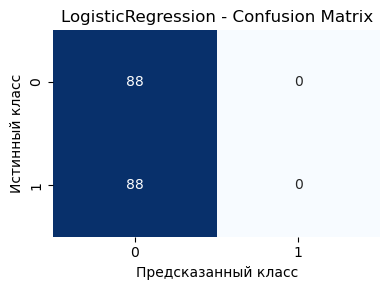


 Обучение модели: KNN


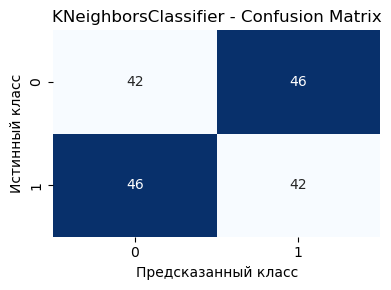


 Обучение модели: Random Forest


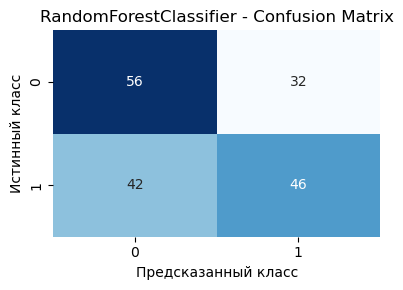


 Обучение модели: Gradient Boosting


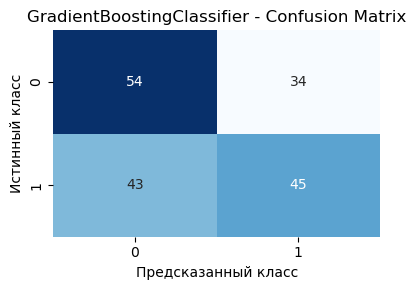


 Обучение модели: HistGradientBoosting


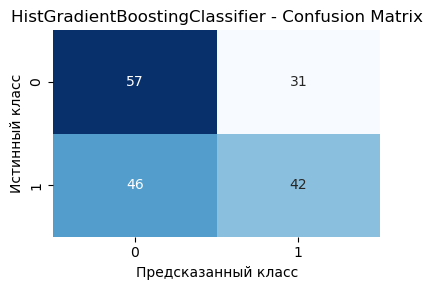


 Обучение модели: XGBoost


C:\Users\NikLeo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


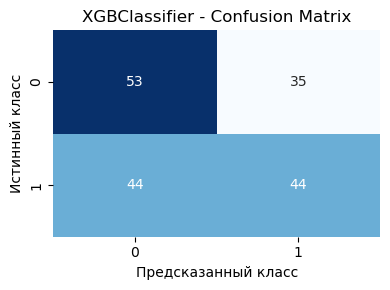


 Обучение модели: CatBoost


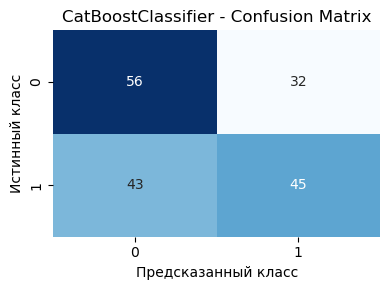


 Обучение модели: Stacking


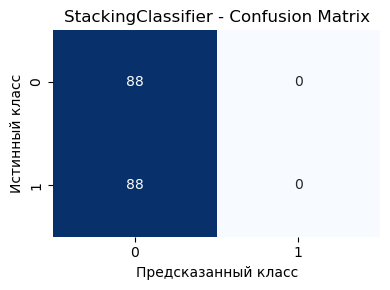

C:\Users\NikLeo\AppData\Local\Temp\ipykernel_8016\1295609280.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


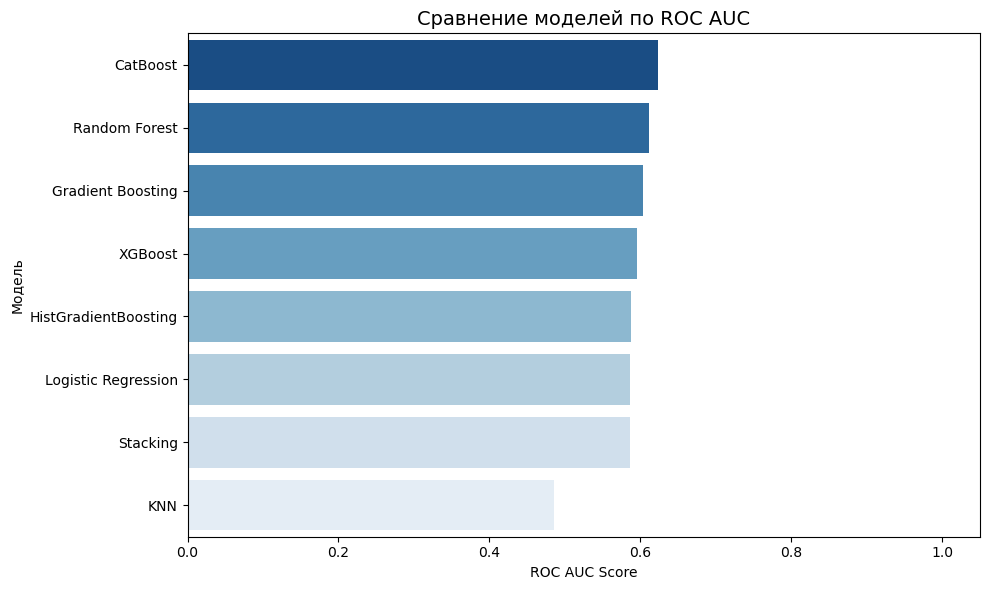


 Итоговые метрики моделей:


,Model,Accuracy,F1,Precision,Recall,ROC AUC
6,CatBoost,0.574,0.545,0.584,0.511,0.623
2,Random Forest,0.580,0.554,0.590,0.523,0.612
3,Gradient Boosting,0.562,0.539,0.570,0.511,0.603
5,XGBoost,0.551,0.527,0.557,0.500,0.596
4,HistGradientBoosting,0.562,0.522,0.575,0.477,0.588
0,Logistic Regression,0.500,0.000,0.000,0.000,0.586
7,Stacking,0.500,0.000,0.000,0.000,0.586
1,KNN,0.477,0.477,0.477,0.477,0.485


In [33]:
#  Сравнение моделей классификации

results = []
best_model = None
best_roc_auc = -np.inf  # Начальное значение для сравнения ROC AUC

for name, model in classification_models.items():
    try:
        print(f"\n Обучение модели: {name}")
        metrics = evaluate_classifier(model, df_engineered, y)  # df_engineered — таблица признаков
        metrics['Model'] = name
        results.append(metrics)

        # Обновляем лучшую модель по метрике ROC AUC
        if metrics['ROC AUC'] > best_roc_auc:
            best_roc_auc = metrics['ROC AUC']
            best_model = model

    except Exception as e:
        print(f" Ошибка при обучении {name}: {str(e)}")

#  Сводная таблица результатов
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False).round(3)

#  График сравнения моделей по ROC AUC
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Model',
    x='ROC AUC',
    data=results_df,
    palette='Blues_r'
)
plt.title('Сравнение моделей по ROC AUC', fontsize=14)
plt.xlabel('ROC AUC Score')
plt.ylabel('Модель')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

#  Таблица с подсветкой лучших и худших значений ROC AUC
def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [('background-color', '#343a40'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffffcc')]}
    ]
    return (df.style
              .set_table_styles(styles)
              .format({
                  'Accuracy': '{:,.3f}',
                  'ROC AUC': '{:,.3f}',
                  'F1': '{:,.3f}',
                  'Precision': '{:,.3f}',
                  'Recall': '{:,.3f}'
              })
              .highlight_max(subset=['ROC AUC'], color='green')  # зелёный для лучших
              .highlight_min(subset=['ROC AUC'], color='red'))  # красный для худших

#  Вывод таблицы
print("\n Итоговые метрики моделей:")
display(display_beautiful_table(results_df))


Обучение модели: Logistic Regression

Обучение модели: KNN

Обучение модели: Random Forest

Обучение модели: Gradient Boosting

Обучение модели: HistGradientBoosting

Обучение модели: XGBoost


C:\Users\NikLeo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:14:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\NikLeo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:14:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\NikLeo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:14:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\NikLeo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:14:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\lear


Обучение модели: CatBoost

Обучение модели: Stacking


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

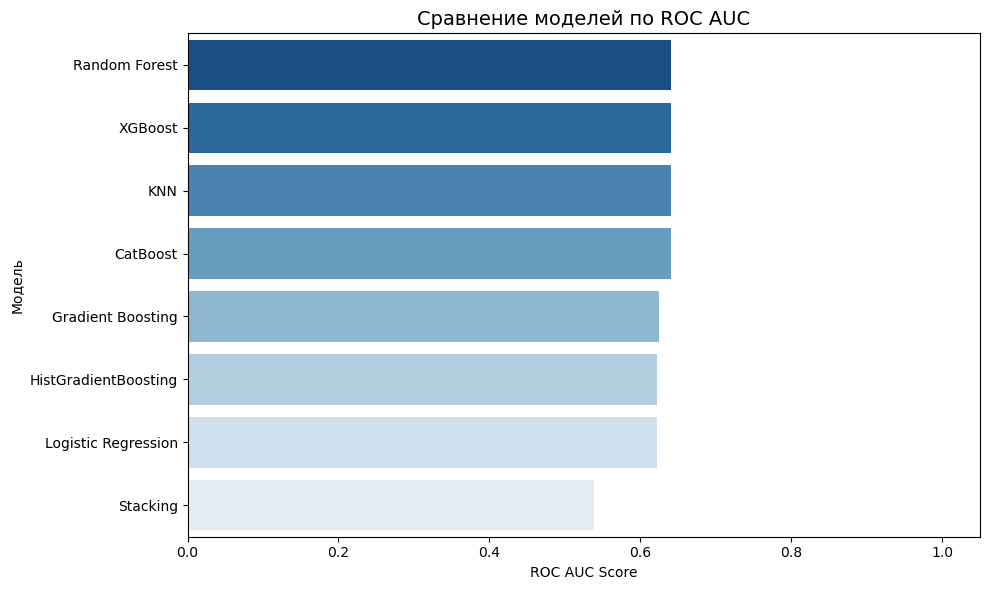


Итоговые метрики моделей:


,Accuracy,F1,Precision,Recall,ROC AUC,Model
2,0.596,0.580,0.602,0.562,0.641,Random Forest
5,0.606,0.596,0.610,0.584,0.641,XGBoost
1,0.614,0.621,0.608,0.637,0.640,KNN
6,0.597,0.586,0.601,0.573,0.640,CatBoost
3,0.591,0.580,0.598,0.568,0.625,Gradient Boosting
4,0.566,0.556,0.568,0.546,0.622,HistGradientBoosting
0,0.595,0.585,0.600,0.573,0.622,Logistic Regression
7,0.524,0.533,0.526,0.545,0.539,Stacking


In [45]:
# --- Сравнение моделей классификации ---
results = []
best_model = None
best_roc_auc = -np.inf  # Начальное значение для сравнения ROC AUC

for name, model in classification_models.items():
    try:
        print(f"\nОбучение модели: {name}")
        metrics = evaluate_classifier(model, df_engineered, y)  # заменили X_selected на df_engineered
        metrics['Model'] = name
        results.append(metrics)

        # Обновляем лучшую модель по метрике ROC AUC
        if metrics['ROC AUC'] > best_roc_auc:
            best_roc_auc = metrics['ROC AUC']
            best_model = model

    except Exception as e:
        print(f"Ошибка при обучении {name}: {str(e)}")

# --- Сводная таблица результатов ---
if results:
    results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False).round(3)

    # --- График сравнения моделей по ROC AUC ---
    plt.figure(figsize=(10, 6))
    sns.barplot(
        y='Model',
        x='ROC AUC',
        data=results_df,
        palette='Blues_r'
    )
    plt.title('Сравнение моделей по ROC AUC', fontsize=14)
    plt.xlabel('ROC AUC Score')
    plt.ylabel('Модель')
    plt.xlim(0, 1.05)
    plt.tight_layout()
    plt.show()

    # --- Таблица с подсветкой лучших и худших значений ROC AUC ---
    def display_beautiful_table(df):
        styles = [
            {'selector': 'th', 'props': [('background-color', '#343a40'),
                                         ('color', 'white'),
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]},
            {'selector': 'td', 'props': [('text-align', 'center')]},
            {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#ffffcc')]}
        ]
        return (df.style
                  .set_table_styles(styles)
                  .format({
                      'Accuracy': '{:,.3f}',
                      'ROC AUC': '{:,.3f}',
                      'F1': '{:,.3f}',
                      'Precision': '{:,.3f}',
                      'Recall': '{:,.3f}'
                  })
                  .highlight_max(subset=['ROC AUC'], color='green')
                  .highlight_min(subset=['ROC AUC'], color='red'))

    # --- Вывод таблицы ---
    print("\nИтоговые метрики моделей:")
    display(display_beautiful_table(results_df))
else:
    print("Ни одна модель не была успешно обучена.")


In [46]:
import joblib

# Сохранение лучшей модели
if best_model is not None:
    # Название лучшей модели из таблицы результатов
    best_model_name = results_df.iloc[0]['Model']
    
    # Имя файла с учетом модели
    filename = f'best_model_for_SI_{best_model_name}.pkl'
    
    # Сохраняем модель с помощью joblib
    joblib.dump(best_model, filename)
    
    print(f"\n Лучшая модель '{best_model_name}' сохранена в файл: {filename}")
else:
    print(" Не удалось сохранить модель: лучшая модель не найдена.")


 Лучшая модель 'Random Forest' сохранена в файл: best_model_for_SI_Random Forest.pkl


### Выводы

Модель KNN продемонстрировала наилучший баланс метрик среди всех алгоритмов, достигнув Accuracy = 61.4% и F1-score = 0.621. Особенно стоит отметить высокий Recall (0.637), что указывает на хорошую способность модели обнаруживать положительные классы. При этом ROC AUC = 0.640 находится на среднем уровне, что может говорить о некоторой ограниченности в ранжировании объектов.

Модели Random Forest, XGBoost и CatBoost показали очень близкие результаты с ROC AUC = 0.640-0.641. Среди них:

XGBoost лидирует по Accuracy (60.6%) и F1-score (0.596)

Random Forest демонстрирует лучшую Precision (0.602), что важно для минимизации ложных срабатываний

CatBoost показывает сбалансированные показатели по всем метрикам

Gradient Boosting и Logistic Regression показали схожие результаты (ROC AUC ≈ 0.622), при этом:

Логистическая регрессия неожиданно превзошла Gradient Boosting по Accuracy (59.5% против 59.1%)

Обе модели демонстрируют сбалансированные Precision-Recall (разница < 0.03)

HistGradientBoosting показал наиболее слабые результаты среди бустинговых методов (ROC AUC = 0.622, Accuracy = 56.6%)

Наименее эффективной оказалась Stacking-модель, значительно уступив всем остальным:

Крайне низкий ROC AUC (0.539) - чуть лучше случайного угадывания

Самая низкая Accuracy (52.4%) среди всех моделей

При этом сохраняется баланс между Precision и Recall

Ключевые наблюдения:

Необычно высокие результаты KNN могут указывать на наличие локальных закономерностей в данных

Все модели показали ROC AUC в узком диапазоне 0.539-0.641, что говорит о средней сложности задачи

Разница между лучшей и худшей моделью по Accuracy составляет всего 9%, что требует дополнительного анализа данных

Stacking-ансамбль не оправдал ожиданий, возможно из-за недостаточного разнообразия базовых моделей